## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from typing import Callable
import warnings
warnings.filterwarnings('ignore')

## Loss function

In [2]:
class MSE:
  def __call__(self, pred_y, true_y):
    self.pred_y = pred_y
    self.true_y = true_y
    return torch.mean((pred_y-true_y)**2)
  
  def backward(self):
    n = self.true_y.shape[0]
    self.gradient = 2.0 * (self.pred_y - self.true_y) / n
    return self.gradient

## Linear layer

In [3]:
class Linear(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super(Linear, self).__init__()
    self.init = torch.rand(input_dim, num_hidden).float()
    self.weights = torch.nn.Parameter(self.init, requires_grad=True)
    self.bias = torch.zeros(num_hidden, )
  
  def __call__(self, X):
    self.X = X
    output = torch.mm(X, self.weights) + self.bias
    return output
  
  def backward(self, gradient):
    self.weights_gradient = torch.mm(torch.transpose(X, 0, 1), gradient)
    self.bias_gradient = gradient.sum(0)
    self.X_gradient = torch.mm(gradient, torch.transpose(self.weights, 0, 1))
    return self.X_gradient

  def update(self, learning_rate):
    self.weights = self.weights - learning_rate * self.weights_gradient
    self.bias = self.bias - learning_rate * self.bias_gradient

## Relu activation function

In [4]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = torch.clamp(self.input_, min=0, out=None)
    return self.output


## Defining model

In [5]:
class Model(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super(Model, self).__init__()
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden,2)

  def forward(self, X):
    l1 = self.linear1(X)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2


## Fit the model

In [6]:
def fit(X, y, model:Callable, loss:Callable, learning_rate, num_epochs):
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred_y = model(X)
    loss_value = loss(pred_y, y)
    if epoch % 5 == 0:
      print(f'Epoch: {epoch}, Loss: {loss_value}')
    loss_value.backward()
    optimizer.step()

## Generate data



In [7]:
no_samples, input_dim, output_dim, learning_rate = 500, 3, 2, 0.01 
X = torch.FloatTensor(no_samples, input_dim).uniform_(-1, 1)

weights_true = torch.tensor([[6, 1, 8],[-3, 1, 3]]).float()
weights_true = torch.transpose(weights_true, 0, 1)
bias_true = torch.tensor([0.5, 1])
true_y = torch.mm(X ** 2, weights_true) + torch.mm(X, weights_true) + bias_true
print(f'X:{X.shape}, y:{true_y.shape}, weights:{weights_true.shape}, bias:{bias_true.shape}')

X:torch.Size([500, 3]), y:torch.Size([500, 2]), weights:torch.Size([3, 2]), bias:torch.Size([2])


## Plotting the data

In [8]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

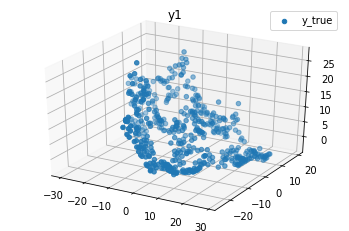

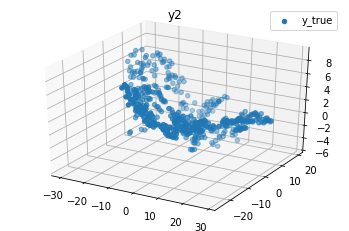

In [9]:
plot_3d('y1', X, true_y[:,0])
plot_3d('y2', X, true_y[:,1])

## Running the model

In [10]:
#running the model for 1 cycle

loss = MSE()
model = Model(input_dim, 10)
pred_y = model(X)
loss_value = loss(pred_y, true_y)

print(f'Loss value: {loss_value}')



Loss value: 28.191940307617188


Epoch: 0, Loss: 28.191940307617188
Epoch: 5, Loss: 25.200611114501953
Epoch: 10, Loss: 22.229339599609375
Epoch: 15, Loss: 19.349870681762695
Epoch: 20, Loss: 16.658681869506836
Epoch: 25, Loss: 14.259330749511719
Epoch: 30, Loss: 12.211896896362305
Epoch: 35, Loss: 10.544937133789062
Epoch: 40, Loss: 9.237102508544922
Epoch: 45, Loss: 8.23967456817627
Epoch: 50, Loss: 7.487786293029785
Epoch: 55, Loss: 6.915487766265869
Epoch: 60, Loss: 6.47083044052124
Epoch: 65, Loss: 6.114649295806885
Epoch: 70, Loss: 5.815615177154541
Epoch: 75, Loss: 5.553897380828857
Epoch: 80, Loss: 5.316866874694824
Epoch: 85, Loss: 5.094417095184326
Epoch: 90, Loss: 4.881736755371094
Epoch: 95, Loss: 4.675032615661621


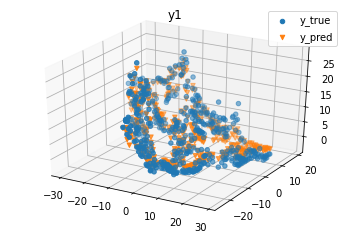

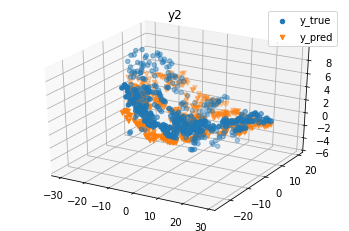

In [11]:
#running for 100 epochs
fit(X, true_y, model=model, loss=loss, learning_rate=learning_rate, num_epochs=100)
pred_y = model(X)
pred_y = pred_y.detach().numpy()
plot_3d('y1', X, true_y[:, 0], pred_y[:, 0])
plot_3d('y2', X, true_y[:, 1], pred_y[:, 1])